In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from networkx.algorithms import community


In [2]:
raw_data = pd.read_csv('all_data_raw.csv',index_col=0)
raw_data

,简称,日期,开盘价(元),收盘价(元),subsector
代码,,,,,
600030.SH,中信证券,2010-01-04,16.50,16.13,资本市场服务
600030.SH,中信证券,2010-01-05,16.26,16.92,资本市场服务
600030.SH,中信证券,2010-01-06,17.01,16.72,资本市场服务
600030.SH,中信证券,2010-01-07,16.71,16.32,资本市场服务
600030.SH,中信证券,2010-01-08,16.21,16.63,资本市场服务
...,...,...,...,...,...
000563.SZ,陕国投A,2021-01-13,3.59,3.51,其他金融业
000563.SZ,陕国投A,2021-01-14,3.49,3.51,其他金融业
000563.SZ,陕国投A,2021-01-15,3.51,3.52,其他金融业


In [3]:
raw_data['month'] = raw_data.apply(lambda x:x['日期'][:-3],axis=1)
raw_data['year'] = raw_data.apply(lambda x:x['日期'][:-6],axis=1)
raw_data['return'] = np.log(raw_data['收盘价(元)'])-np.log(raw_data['开盘价(元)'])

In [4]:
mutiIndex = list(zip(raw_data['month'],raw_data['简称']))
index = pd.MultiIndex.from_tuples(mutiIndex,names=['month','简称'])
raw_data.set_index(index)

简称          日期  开盘价(元)  收盘价(元) subsector    month  year  \
month   简称                                                                
2010-01 中信证券  中信证券  2010-01-04   16.50   16.13    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-05   16.26   16.92    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-06   17.01   16.72    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-07   16.71   16.32    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-08   16.21   16.63    资本市场服务  2010-01  2010   
...            ...         ...     ...     ...       ...      ...   ...   
2021-01 陕国投A  陕国投A  2021-01-13    3.59    3.51     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-14    3.49    3.51     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-15    3.51    3.52     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-18    3.50    3.54     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-19    3.53    3.60     其他金融业  2021-01  2021   

                return  
month   简称              
2010-01 中信证券 -0.022679  
        中信证券  0.039788  
        中信证券 -0.017196  
        中信证券 -0.023616  
        中信证券  0.025580  
...                ...  
2021-01 陕国投A -0.022536  
        陕国投A  0.005714  
        陕国投A  0.002845  
        陕国投A  0.011364  
        陕国投A  0.019636  

[230203 rows x 8 columns]

In [5]:
one_month = raw_data[raw_data['month']=='2020-11']
# one_month[one_month['简称']=='中信证券']

In [6]:
pivot_m = pd.pivot_table(data=one_month,values='return',columns='简称',index='日期')
# pivot_m

In [7]:
corr=pivot_m.corr()
# corr

In [9]:
# print(sum(np.sum(corr.isna())))

In [8]:
distance_m = np.sqrt(2*(1-corr))
# distance_m

In [10]:
zipped = []
for i in range(len(distance_m.columns)):
    zipped.append(list(zip([distance_m.columns[i]]*distance_m.shape[0],distance_m.index,distance_m[distance_m.columns[i]])))
List_flat = []
for i in zipped:
    for j in i:
        # print(j)
        # print(type(j[2]))
        if not np.isnan(j[2]):
            # print(j[2])
            List_flat.append(j)
s_List_flat = list(set(List_flat))
G = nx.Graph()
for i in range(len(distance_m.columns)):
    G.add_node(distance_m.columns[i])
G.add_weighted_edges_from(s_List_flat)

In [11]:
mst = nx.minimum_spanning_tree(G=G)

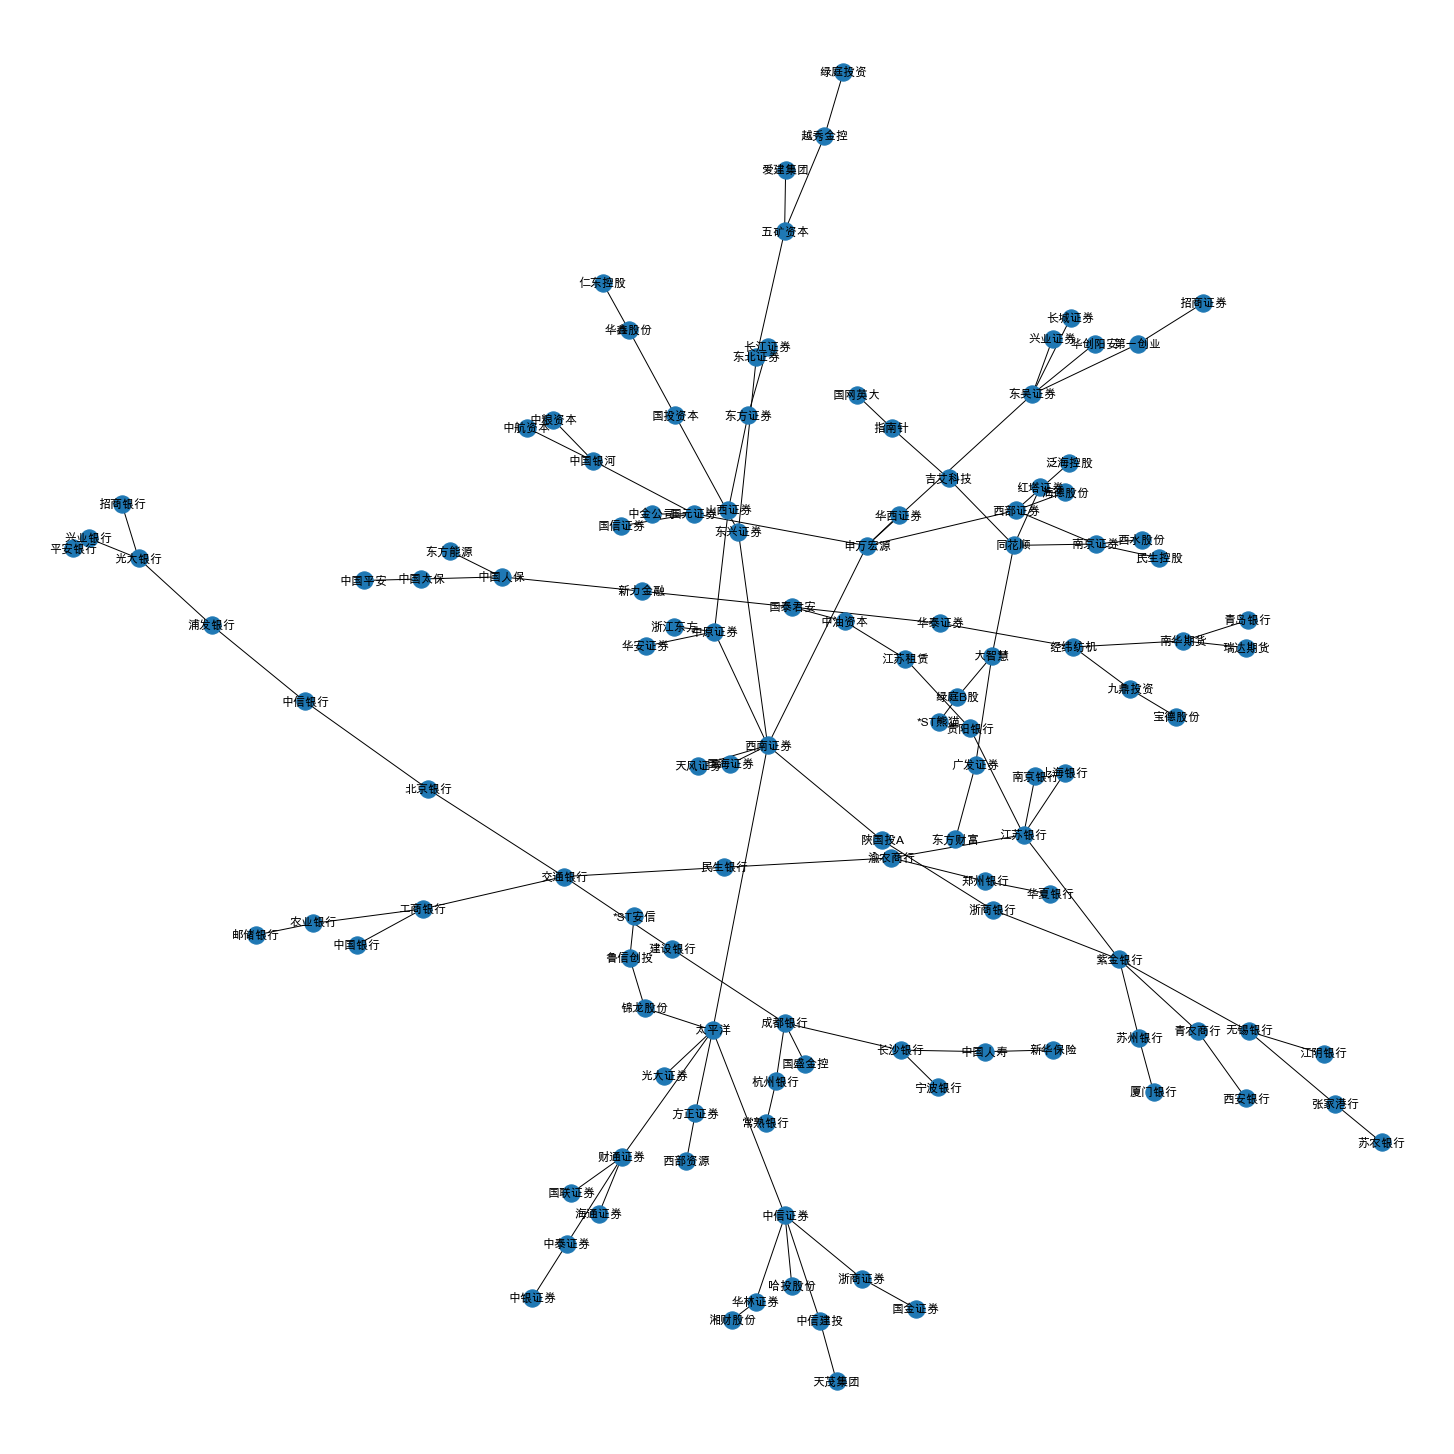

In [12]:
plt.figure(figsize=(20,20))

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw_spring(mst,with_labels=True,)

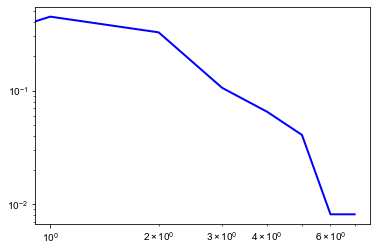

In [13]:
degree =  nx.degree_histogram(mst)          
x = range(len(degree))                             
y = [z / float(sum(degree)) for z in degree] 
plt.loglog(x,y,color="blue",linewidth=2)          
plt.show()                                                          

In [14]:
communities_generator = community.girvan_newman(mst)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
color_c = sorted(map(sorted, next_level_communities))
print(len(color_c))

3


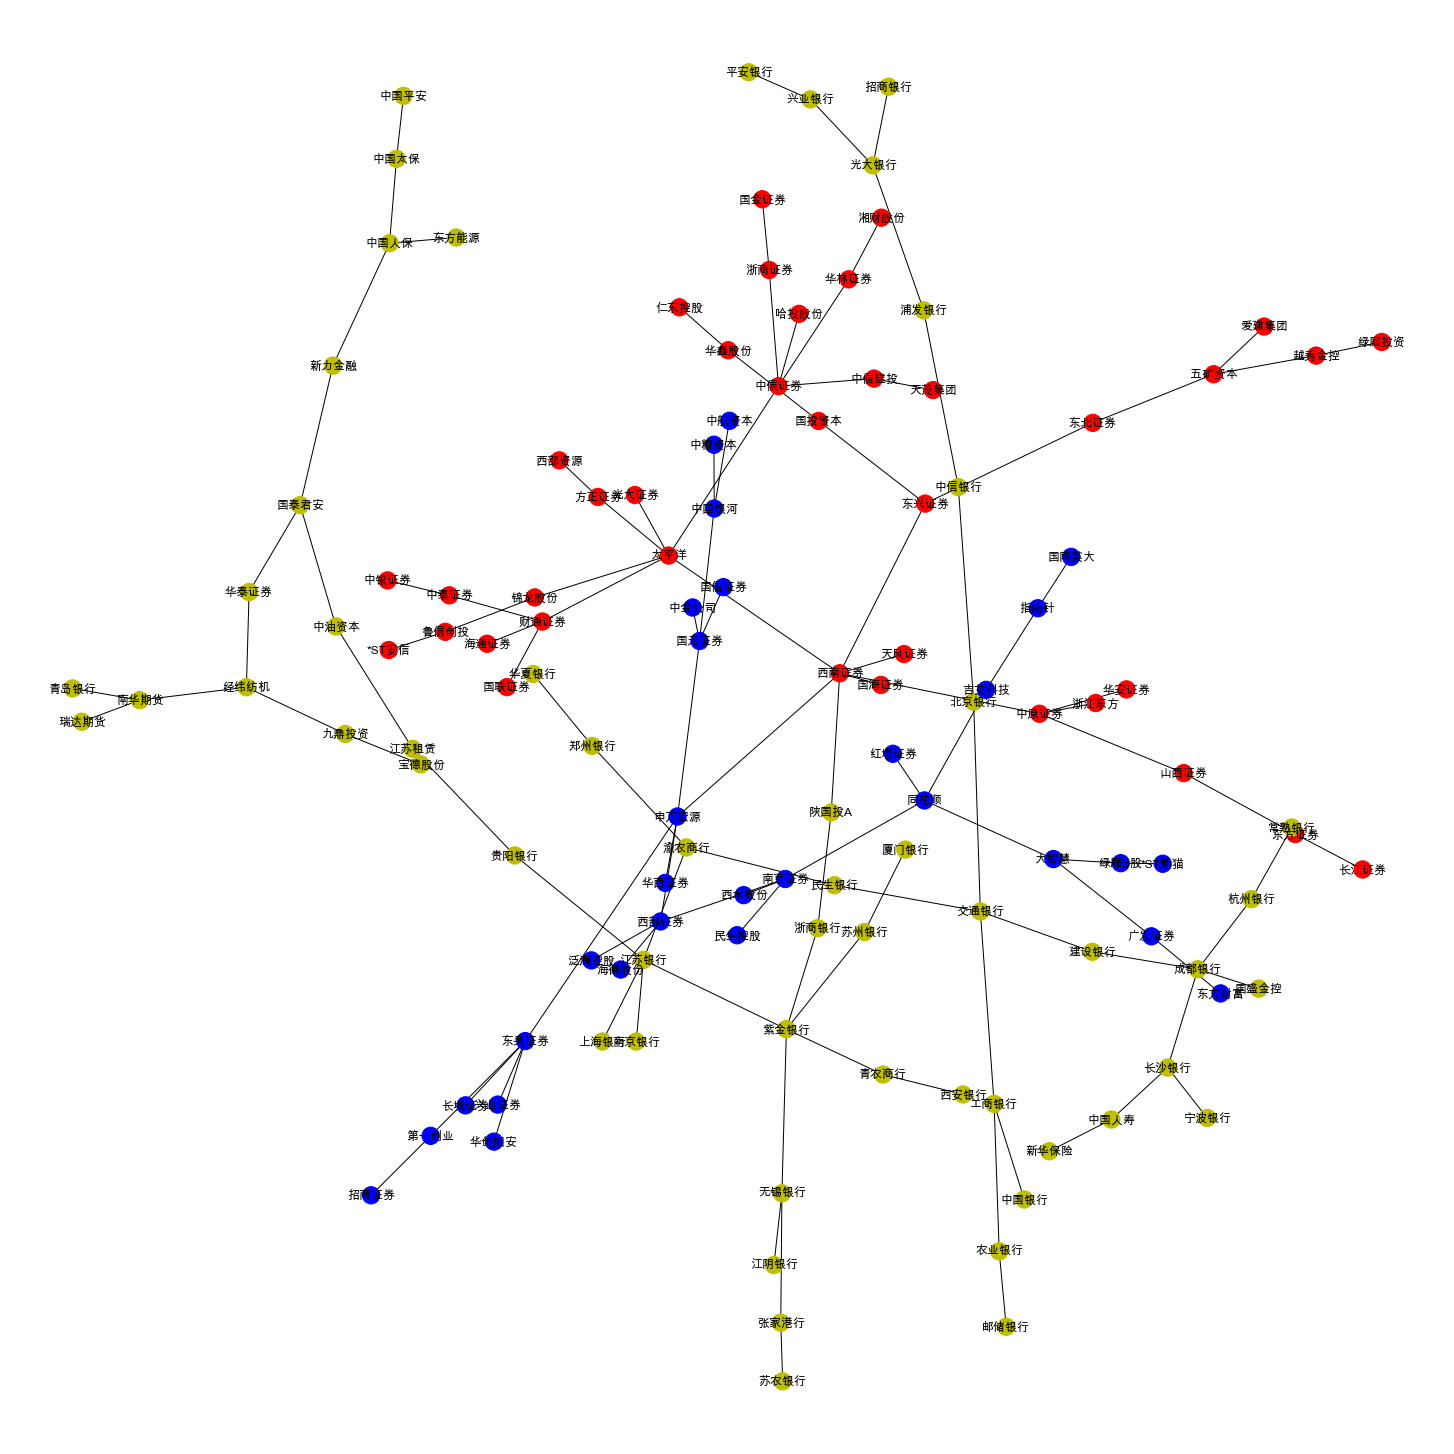

In [15]:
color = ['red','blue','yellow']
color_map = []
for node in mst:
    # print(node)
    if node in color_c[0]:
        color_map.append(color[0][0])
    elif node in color_c[1]:
        color_map.append(color[1][0])
    else:
        color_map.append(color[2][0])        
plt.figure(figsize=(20,20))
nx.draw_spring(mst,node_color = color_map,with_labels = True)

In [16]:
# nx.write_gexf(mst,'mst_2010_11.gexf')

In [17]:
import planarity

def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True),
                                     key=lambda x: x[2]['weight']):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
        
    return sorted_edges
def compute_PMFG(sorted_edges, nb_nodes):
    PMFG = nx.Graph()
    for edge in sorted_edges:
        PMFG.add_edge(edge['source'], edge['dest'])
        if not planarity.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
            
        if len(PMFG.edges()) == 3*(nb_nodes-2):
            break
    
    return PMFG

In [18]:
sorted_edges = sort_graph_edges(G)
print(len(sorted_edges))

7626


In [ ]:
start = time.time()
PMFG = compute_PMFG(sorted_edges, len(G.nodes))
end = time.time()
print('time used: ', end-start)

In [ ]:
nx.draw_spring(PMFG,with_labels=True)

In [ ]:
# def compute_PMFG(sorted_edges, nb_nodes):
#     PMFG = nx.Graph()
#     for edge in sorted_edges:
#         PMFG.add_edge(edge['source'], edge['dest'])
#         if not planarity.is_planar(PMFG):
#             PMFG.remove_edge(edge['source'], edge['dest'])
            
#         if len(PMFG.edges()) == 3*(nb_nodes-2):
#             break
    
#     return PMFG